<a href="https://colab.research.google.com/github/sierrarowley/research_fall2020/blob/master/data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

generate_dense and generate_sparse are functions that create databases that are specifically dense and sparse. These ensure that some dense and some sparse databases will be used as input to the nn. This also allows there to be a smaller number of points in the database to make the neural net run faster.

In [2]:
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import math

xbound = 10
ybound = 10
point_bound = 1000   # for generatedata()


def generatedata():
  db = np.empty((xbound, ybound), dtype=object)
  # create random number of points
  for n in range(0, random.randint(1, point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    # at most 10 values per point
    elif len(db[x, y]) < 10:
      db[x, y].append(enc)
  
  return db


extra_point_bound = 50   # for generate_dense()

def generate_dense():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  xsprinkle = []
  ysprinkle = []
  # create point at each index
  for x in range(0, xbound):
    for y in range(0, ybound):
      # encrypt value of point
      randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
      enc = hash(randstring + str(x) + str(y))
      # store encrypted point in the database
      db[x, y] = [enc]
      xvalues.append(x)
      yvalues.append(y)

  # sprinkle random number of extra points around db
  for n in range(0, random.randint(1, extra_point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)
    xsprinkle.append(x)
    ysprinkle.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))
    db[x, y].append(enc)

  return db, xvalues, yvalues, xsprinkle, ysprinkle


sparse_point_bound = 150   # for generate_sparse()

def generate_sparse():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  # create random number of points
  for n in range(0, random.randint(1, sparse_point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)
    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  return db, xvalues, yvalues


small_point_bound = 5   # for generate_sparse_small()

def generate_sparse_small():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  # create random number of points
  for n in range(0, random.randint(1, small_point_bound)):
    if n%2:
      x = random.randint(0, int((xbound-1)/2))
      y = random.randint(0, int((ybound-1)/2))
    else:
      x = random.randint(int((xbound-1)/2), xbound-1)
      y = random.randint(int((ybound-1)/2), ybound-1)
    xvalues.append(x)
    yvalues.append(y)
    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  return db, xvalues, yvalues


def generate_dense_exact():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []

  # create point at each index
  for x in range(0, xbound):
    for y in range(0, ybound):
      # encrypt value of point
      randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
      enc = hash(randstring + str(x) + str(y))
      # store encrypted point in the database
      db[x, y] = [enc]
      xvalues.append(x)
      yvalues.append(y)

  return db, xvalues, yvalues


def generate_sparse_cluster():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  x_range = int((xbound-1)/4)

  for n in range(0, random.randint(50, 70)):
    x = random.randint(0, x_range)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  for n in range(0, random.randint(20, 50)):
    x = random.randint(x_range, x_range*2)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  for n in range(0, random.randint(10, 20)):
    x = random.randint(x_range*2, x_range*3)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  for n in range(0, random.randint(1, 10)):
    x = random.randint(x_range*3, x_range*4)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  return db, xvalues, yvalues

In [3]:
from google.colab import files 
import pandas as pd 
import io 

uploaded = files.upload()
crimesmap_pd = pd.read_csv(io.BytesIO(uploaded['crimesmap2.csv']))
crimesmap_pd.head()

Saving crimesmap2.csv to crimesmap2.csv


,CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,JD373159,09/20/2020 05:45:00 AM,040XX E 134TH ST,560,ASSAULT,SIMPLE,RESIDENCE,N,Y,433,10,08A,1204544,1816604,41.651431,-87.527258,"(41.651431329, -87.527258234)"
1,JC517391,11/19/2019 02:11:00 PM,040XX E 134TH ST,890,THEFT,FROM BUILDING,RESIDENCE PORCH/HALLWAY,N,N,433,10,6,1204544,1816604,41.651431,-87.527258,"(41.651431329, -87.527258234)"
2,JD378697,09/25/2020 10:42:00 AM,040XX E 134TH ST,530,ASSAULT,AGGRAVATED - OTHER DANGEROUS WEAPON,STREET,N,N,433,10,04A,1204544,1816604,41.651431,-87.527258,"(41.651431329, -87.527258234)"
3,JD379866,09/26/2020 10:32:00 AM,040XX E 134TH ST,1310,CRIMINAL DAMAGE,TO PROPERTY,OTHER (SPECIFY),N,Y,433,10,14,1204544,1816604,41.651431,-87.527258,"(41.651431329, -87.527258234)"
4,JC501181,11/06/2019 06:49:00 PM,040XX E 134TH ST,460,BATTERY,SIMPLE,STREET,N,N,433,10,08B,1204544,1816604,41.651431,-87.527258,"(41.651431329, -87.527258234)"


In [4]:
uploaded2 = files.upload()
providence_tt_pd = pd.read_csv(io.BytesIO(uploaded2['prov_data_tt.csv']))
providence_tt_pd.head()

Saving prov_data_tt.csv to prov_data_tt.csv


,Unnamed: 0,0,1
0,0,7,40
1,1,7,58
2,2,7,40
3,3,7,40
4,4,8,50


In [5]:
uploaded3 = files.upload()
providence_ll_pd = pd.read_csv(io.BytesIO(uploaded3['prov_data_ll.csv']))
providence_ll_pd.head()

Saving prov_data_ll.csv to prov_data_ll.csv


,Unnamed: 0,0,1
0,0,41.815812,-71.439025
1,1,41.815812,-71.439025
2,2,41.819713,-71.416844
3,3,41.813343,-71.426468
4,4,41.826427,-71.410074


In [6]:
def chicago_preprocess(crimesmap_pd_input):
  crimesmap = np.array(crimesmap_pd_input)
  # select lattitude and longitude columns from crimes map data set
  crimesmap_ll = crimesmap[:, 14:16]
  # select time and type of crime columns from data
  crimesmap_tt = np.column_stack((crimesmap[:, 1], crimesmap[:, 4]))

  # give crime number for each type of crime
  crime_type = set(crimesmap[:, 4])
  type_map = {i: n for n,i in enumerate(crime_type)}

  row = crimesmap_ll.shape[0] - 1
  while row >= 0:
    # remove all nan rows from lattitude longitude data
    if math.isnan(crimesmap_ll[row, 0]) or math.isnan(crimesmap_ll[row, 1]):
      crimesmap_ll = np.delete(crimesmap_ll, row, axis=0)

    # set crime type at this row to be the corresponding number
    crimesmap_tt[row, 1] = type_map[crimesmap_tt[row, 1]]
    # isolate time from date of occurance
    crimesmap_tt[row, 0] = int(crimesmap_tt[row, 0][11: 13]) #+ crimesmap_tt[row, 0][14: 16])

    row -= 1

  return crimesmap_ll, crimesmap_tt

def prov_preprocess(prov_ll_pd_input, prov_tt_pd_input):
  tt = np.array(providence_tt_pd)[:, 1:]
  ll = np.array(providence_ll_pd)[:, 1:]
  return ll, tt

In [7]:
def crimes_data(crimesmap, ll_flag):
  # take a random set of 50 data entries
  start = random.randint(0, crimesmap.shape[0]-50)
  crimesmap = crimesmap[start:start+51, :]

  # normalize data so smallest entry is equivalent to 0 and numbers are in range of 10s place
  db_min = np.argmin(crimesmap, axis=0)
  min_0 = crimesmap[db_min[0],0]
  min_1 = crimesmap[db_min[1],1]
  for r in range(crimesmap.shape[0]):
    if ll_flag:
      # if the normalized lat and long values are too big, the array will be too big and timeout
      if int(round((crimesmap[r, 0] - min_0)*1000)) > 50 or int(round((crimesmap[r, 1] - min_1)*1000)) > 50:
        crimesmap[r, 0] = int(round((crimesmap[r, 0] - min_0)*1000)/10)
        crimesmap[r, 1] = int(round((crimesmap[r, 1] - min_1)*1000)/10)
      else:
        crimesmap[r, 0] = int(round((crimesmap[r, 0] - min_0)*1000))
        crimesmap[r, 1] = int(round((crimesmap[r, 1] - min_1)*1000))
    else:
      crimesmap[r, 0] = crimesmap[r, 0] - min_0
      crimesmap[r, 1] = crimesmap[r, 1] - min_1

  # get max x and y coordinates to determine size of database
  db_maxsize = np.argmax(crimesmap, axis=0)
  db = np.empty((int(crimesmap[db_maxsize[0],0])+1, int(crimesmap[db_maxsize[1], 1])+1), dtype=object)
  xvalues = []
  yvalues = []
  # add each x, y coordinate to the database as a hashed value
  for n in range(0, crimesmap.shape[0]):
    x = int(crimesmap[n, 0])
    y = int(crimesmap[n, 1])

    xvalues.append(x)
    yvalues.append(y)

    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))
    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  return db, xvalues, yvalues

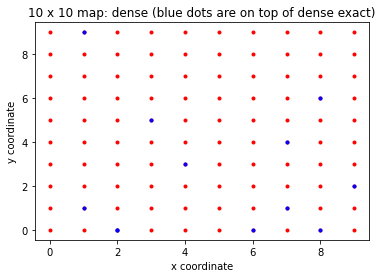

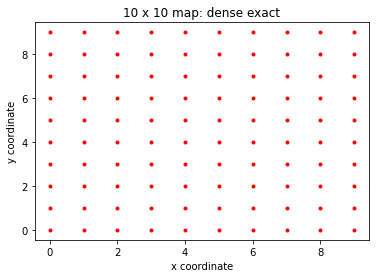

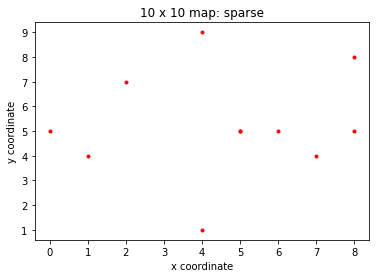

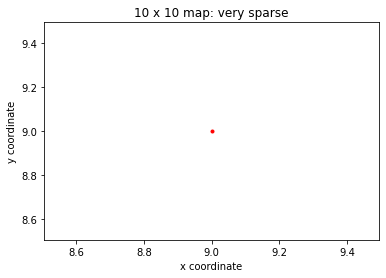

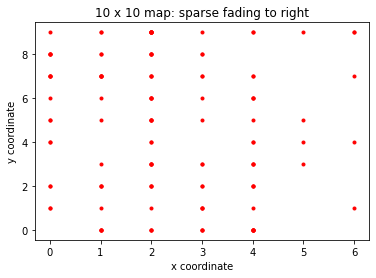

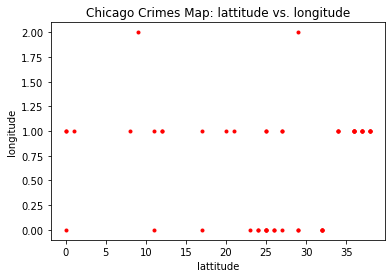

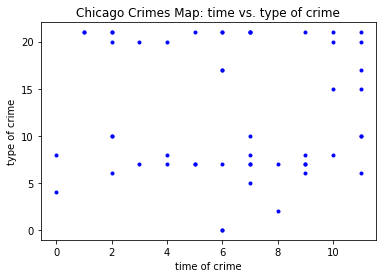

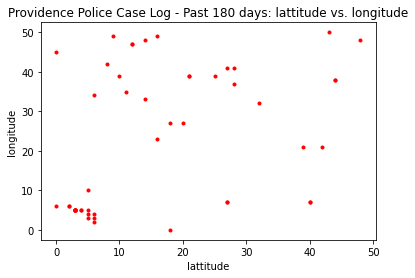

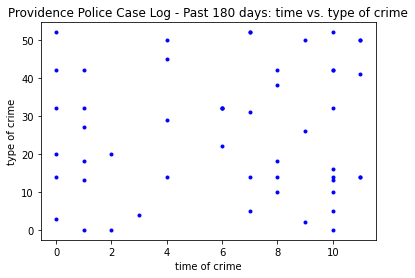

In [8]:
def plot_databases():  
  # dense
  db, xvalues, yvalues, xsprinkle, ysprinkle = generate_dense()
  plt.plot(xvalues, yvalues, 'r.')
  plt.plot(xsprinkle, ysprinkle, 'b.')
  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.title("10 x 10 map: dense (blue dots are on top of dense exact)")
  plt.show()
  
  # dense exact
  db, xvalues, yvalues = generate_dense_exact()
  plt.plot(xvalues, yvalues, 'r.')
  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.title("10 x 10 map: dense exact")
  plt.show()
  
  # sparse
  db, xvalues, yvalues = generate_sparse()
  plt.plot(xvalues, yvalues, 'r.')
  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.title("10 x 10 map: sparse")
  plt.show()
  
  # sparse small
  db, xvalues, yvalues = generate_sparse_small()
  plt.plot(xvalues, yvalues, 'r.')
  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.title("10 x 10 map: very sparse")
  plt.show()
  
  # sparse fade
  db, xvalues, yvalues = generate_sparse_cluster()
  plt.plot(xvalues, yvalues, 'r.')
  plt.xlabel('x coordinate')
  plt.ylabel('y coordinate')
  plt.title("10 x 10 map: sparse fading to right")
  plt.show()

  # lattitude vs. longitude
  db, xvalues, yvalues = crimes_data(chicago_preprocess(crimesmap_pd)[0], 1)
  plt.plot(xvalues, yvalues, 'r.')
  plt.xlabel('lattitude')
  plt.ylabel('longitude')
  plt.title("Chicago Crimes Map: lattitude vs. longitude")
  plt.show()
  
  # time vs. type
  db, xvalues, yvalues = crimes_data(chicago_preprocess(crimesmap_pd)[1], 0)
  plt.plot(xvalues, yvalues, 'b.')
  plt.xlabel('time of crime')
  plt.ylabel('type of crime')
  plt.title("Chicago Crimes Map: time vs. type of crime")
  plt.show()

  # lattitude vs. longitude
  db, xvalues, yvalues = crimes_data(prov_preprocess(providence_ll_pd, providence_tt_pd)[0], 1)
  plt.plot(xvalues, yvalues, 'r.')
  plt.xlabel('lattitude')
  plt.ylabel('longitude')
  plt.title("Providence Police Case Log - Past 180 days: lattitude vs. longitude")
  plt.show()
  
  # time vs. type
  db, xvalues, yvalues = crimes_data(prov_preprocess(providence_ll_pd, providence_tt_pd)[1], 0)
  plt.plot(xvalues, yvalues, 'b.')
  plt.xlabel('time of crime')
  plt.ylabel('type of crime')
  plt.title("Providence Police Case Log - Past 180 days: time vs. type of crime")
  plt.show()

plot_databases()

produce_leakage() performs every possible query of the database and saves the results from those queries in a list. The list is returned at the end. The 10x10 database is classified as very sparse (0), sparse (1), or dense (2). 

In [9]:
max_rect_l = 5
max_rect_w = 5

def produce_leakage(db):
  xbound = db.shape[0]
  ybound = db.shape[1]
  leakage = []
  empty_query_rows = [] # keep track of empty rows(queries) for padding purposes
  query_num = 0 # keep track of row(query) number for empty_query_rows
  querylen = 0
  # all possible size rectangle queries up to 5x5 for colab storage reasons
  for l in range(1, max_rect_l+1):
    for w in range(1, max_rect_w+1):
      # all possible starting points of the rectangle query
      for x in range(0, xbound):
        # dont perform query if it is out of bounds
        if x+l > xbound:
          break
        for y in range(0, ybound):
          if y+w > ybound:
            break

          curr_query = []
          # loop through current query in the database
          for i in range(x, x+l):
            for j in range(y, y+w):
              # if a point(s) exists at this location in database, add it to the current query
              if db[i, j] != None:
                curr_query.extend(db[i, j])

          # if query is empty, then add [-1] to represent empty         
          if not curr_query:
            leakage.append([-1])
            # keep track of empty queries for padding later
            empty_query_rows.append(query_num)
          # else add query leakage to entire leakage list
          else :
            leakage.append(curr_query)

          # keep track of longest query length for creating input array
          if len(curr_query) > querylen:
            querylen = len(curr_query)
          query_num += 1

  return (leakage, empty_query_rows, querylen)


def classify(db):
  xbound = db.shape[0]
  ybound = db.shape[1]
  db_density = 0 # keep track of how many indices in db are empty for classification
  for x in range(0, xbound):
      for y in range(0, ybound):
        # count number of empty indices in database to find density classification
        if db[x, y] == None:
          db_density += 1

  density = (100 - db_density)/100
  dense_class = 0
  if density >= 0.4 and density < 1:
    dense_class = 1
  elif density >= 1:
    dense_class = 2

  return dense_class

create_database() calls some database generating function depending on the input parameter and produce_leakage(), which creates the database and the search query leakages from that database. It then takes the returned list of leakages and transforms it into a 2D numpy array with dimensions (number of queries, length of longest query). All queries with a length shorter than the longest are padded with 0's at the end. Each index of the array represents hashed value of a point in a query. create_database() returns the numpy array, which represents one input to the neural net, and the classification of the database.

In [10]:
def create_database(db_func):
  db = None
  if "chi" in db_func:
    if "latlong" in db_func:
      db = crimes_data(chicago_preprocess(crimesmap_pd)[0], 1)[0]
    elif "timetype" in db_func:
      db = crimes_data(chicago_preprocess(crimesmap_pd)[1], 0)[0]
  elif "prov" in db_func:
    if "latlong" in db_func:
      db = crimes_data(prov_preprocess(providence_ll_pd, providence_tt_pd)[0], 1)[0]
    elif "timetype" in db_func:
      db = crimes_data(prov_preprocess(providence_ll_pd, providence_tt_pd)[1], 0)[0]
  elif db_func == "dense":
    db = generate_dense()[0]
  elif db_func == "dense_exact":
    db = generate_dense_exact()[0]
  elif db_func == "sparse":
    db = generate_sparse()[0]
  elif db_func == "sparse_small":
    db = generate_sparse_small()[0]
  else:
    db = generate_sparse_cluster()[0]

  leakage, empty_rows, querylen = produce_leakage(db)
  if "latlong" in db_func:
    c = 0
  elif "timetype" in db_func:
    c = 1
  else:
    c = classify(db)

  numqueries = len(leakage)
  input = np.empty((numqueries, querylen))
  for x in range(0, numqueries):
    q = np.array(leakage[x])
    # empty rows are padded with -1 to distinguish them
    if x in empty_rows:
      input[x] = np.pad(q, (0, querylen-len(q)), 'constant', constant_values=(0, -1))
    # all other queries are padded with 0 to be same shape
    else:
      input[x] = np.pad(q, (0, querylen-len(q)), 'constant', constant_values=(0, 0))

  # shuffle leakage to make order and location of queries less obvious
  np.random.shuffle(input)
  
  return (input, c)

create_nn_data() creates a specified number of databases that will be used in the training and testing sets for the neural net. It pads each input array (from create_database) so they are all of the same size. It returns an array of inputs of size (number of inputs, number of queries, number of items in query) and an array of the labels.

In [11]:
def create_nn_data(num_inputs, data_type):
  data = [] # list to store each database
  labels = np.zeros((num_inputs))
  numqueries = 0
  querylen = 0
  db_func_list = ["dense", "dense_exact", "sparse", "sparse_small", "sparse_cluster"]
  chi_crimes_func_list = ["chi_latlong", "chi_timetype"]
  prov_crimes_func_list = ["prov_latlong", "prov_timetype"]

  # create all databases for input
  for n in range(0, num_inputs):
    if data_type == 0:
      db_func = random.choice(db_func_list)
    elif data_type == 1:
      db_func = random.choice(chi_crimes_func_list)
    else:
      db_func = random.choice(prov_crimes_func_list)
    database, label = create_database(db_func)
    data.append(database)
    labels[n] = label

    # find largest shape to later pad all databases to be same size
    if database.shape[0] > numqueries:
      numqueries = database.shape[0]
    if database.shape[1] > querylen:
      querylen = database.shape[1]

  inputs = np.empty((num_inputs, numqueries, querylen))
  # pad each database
  for i in range(0, len(data)):
    d = data[i]
    d = np.pad(d, ((0, 0), (0, max(querylen - d.shape[1], 0))), 'constant', constant_values=(0, 0))
    d = np.pad(d, ((0, max(numqueries - d.shape[0], 0)), (0, 0)), 'constant', constant_values=(0, 0))
    inputs[i] = d

  return inputs, labels

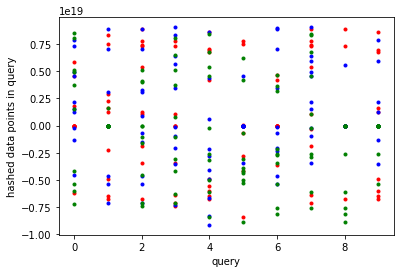

In [12]:
data, labels = create_nn_data(3, 0)

def plot_hashed_query_data():
  plt.plot(data[0, 0:10, 0:10], 'r.')
  plt.plot(data[1, 0:10, 0:10], 'b.')
  plt.plot(data[2, 0:10, 0:10], 'g.')
  plt.xlabel('query')
  plt.ylabel('hashed data points in query')
  plt.show()

plot_hashed_query_data()

Time to make the neural net! I will be using tensorflow with keras

In [13]:
import tensorflow as tf
from tensorflow import keras

In [24]:
# preprocess data
n = 1500
e = 7 #3
num_classes = 3 #2
# second input is for type of databases to use: 0 = 10x10, 1 = chicago crimes map, 2 = providence crimes map
inputs, labels = create_nn_data(n, 0)

train_inputs = inputs[0:int(n*.8), :, :, None]
train_labels = labels[0:int(n*.8)]
test_inputs = inputs[int(n*.8):n, :, :, None]
test_labels = labels[int(n*.8):n]

print("train inputs: ", train_inputs.shape, "train labels: ", train_labels.shape)
print("test inputs: ", test_inputs.shape, "test labels: ", test_labels.shape)

# create model
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(96, 3, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(96, 3, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_inputs, train_labels, epochs=e)

test_loss, test_acc = model.evaluate(test_inputs,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

# see which databases were being classified incorrectly the most
actual_incorrect = []
predict_incorrect = []
predictions = np.argmax(model.predict(test_inputs), axis=1)
for i in range(len(predictions)):
  if predictions[i] != test_labels[i]:
    actual_incorrect.append(test_labels[i])
    predict_incorrect.append(predictions[i])
print("databases incorrectly predicted: ", 
      "\n times incorrect when actual was 0: ", actual_incorrect.count(0), " predicted 0: ", predict_incorrect.count(0),
      "\n times incorrect when actual was 1: ", actual_incorrect.count(1), " predicted 1: ", predict_incorrect.count(1),
      "\n times incorrect when actual was 2: ", actual_incorrect.count(2), " predicted 2: ", predict_incorrect.count(2))

train inputs:  (1200, 1600, 74, 1) train labels:  (1200,)
test inputs:  (300, 1600, 74, 1) test labels:  (300,)
Epoch 1/7
38/38 [==============================] - 97s 3s/step - loss: 9855401608609792.0000 - accuracy: 0.6508
Epoch 2/7
38/38 [==============================] - 97s 3s/step - loss: 28572324462592.0000 - accuracy: 0.8383
Epoch 3/7
38/38 [==============================] - 96s 3s/step - loss: 11849171992576.0000 - accuracy: 0.8458
Epoch 4/7
38/38 [==============================] - 97s 3s/step - loss: 7175126122496.0000 - accuracy: 0.8992
Epoch 5/7
38/38 [==============================] - 97s 3s/step - loss: 6073350094848.0000 - accuracy: 0.9042
Epoch 6/7
38/38 [==============================] - 98s 3s/step - loss: 3082902568960.0000 - accuracy: 0.9292
Epoch 7/7
38/38 [==============================] - 96s 3s/step - loss: 3855392702464.0000 - accuracy: 0.9367
10/10 - 6s - loss: 20998376128512.0000 - accuracy: 0.8433

Test accuracy: 0.8433333039283752
databases incorrectly predi

In [30]:
# see exactly how the model went wrong
zero = 0
zero_1 = 0
zero_2 = 0
one = 0
one_0 = 0
one_2 = 0
two = 0
two_0 = 0
two_1 = 0

for i in range(len(actual_incorrect)):
  if actual_incorrect[i] == 0:
    zero += 1
    if predict_incorrect[i] == 1:
      zero_1 += 1
    else:
      zero_2 += 1
  if actual_incorrect[i] == 1:
    one += 1
    if predict_incorrect[i] == 0:
      one_0 += 1
    else:
      one_2 += 1
  if actual_incorrect[i] == 2:
    two += 1
    if predict_incorrect[i] == 0:
      two_0 += 1
    else:
      two_1 += 1

print("actual 0: ", zero, "\n  predicted 1: ", zero_1, "\n  predicted 2: ", zero_2)
print("\nactual 1: ", one, "\n  predicted 0: ", one_0, "\n  predicted 2: ", one_2)
print("\nactual 2: ", two, "\n  predicted 0: ", two_0, "\n  predicted 1: ", two_1)

actual 0:  1 
  predicted 1:  1 
  predicted 2:  0

actual 1:  33 
  predicted 0:  4 
  predicted 2:  29

actual 2:  13 
  predicted 0:  0 
  predicted 1:  13
